In [1]:
import h5py

In [2]:
from keras.applications.vgg16 import VGG16
from keras import backend as K

Using TensorFlow backend.


In [3]:
# 필터 시각화를 위한 손실 텐서 정의하기
model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [4]:
# 입력에 대한 손실의 그래디언트 구하기
grads = K.gradients(loss, model.input)[0]

In [5]:
# 그래디언트 정규화하기
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [6]:
# 입력 값에 대한 넘파이 출력 값 추출하기
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [7]:
# 확률적 경사 상승법을 사용한 손실 최대화하기
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

In [8]:
# 텐서를 이미지 형태로 변환하기 위한 유틸리티 함수
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x*= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
# 필터 시각화 이미지를 만드는 함수
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
    
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

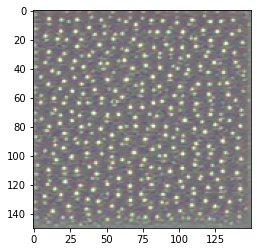

In [10]:
from matplotlib import pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))

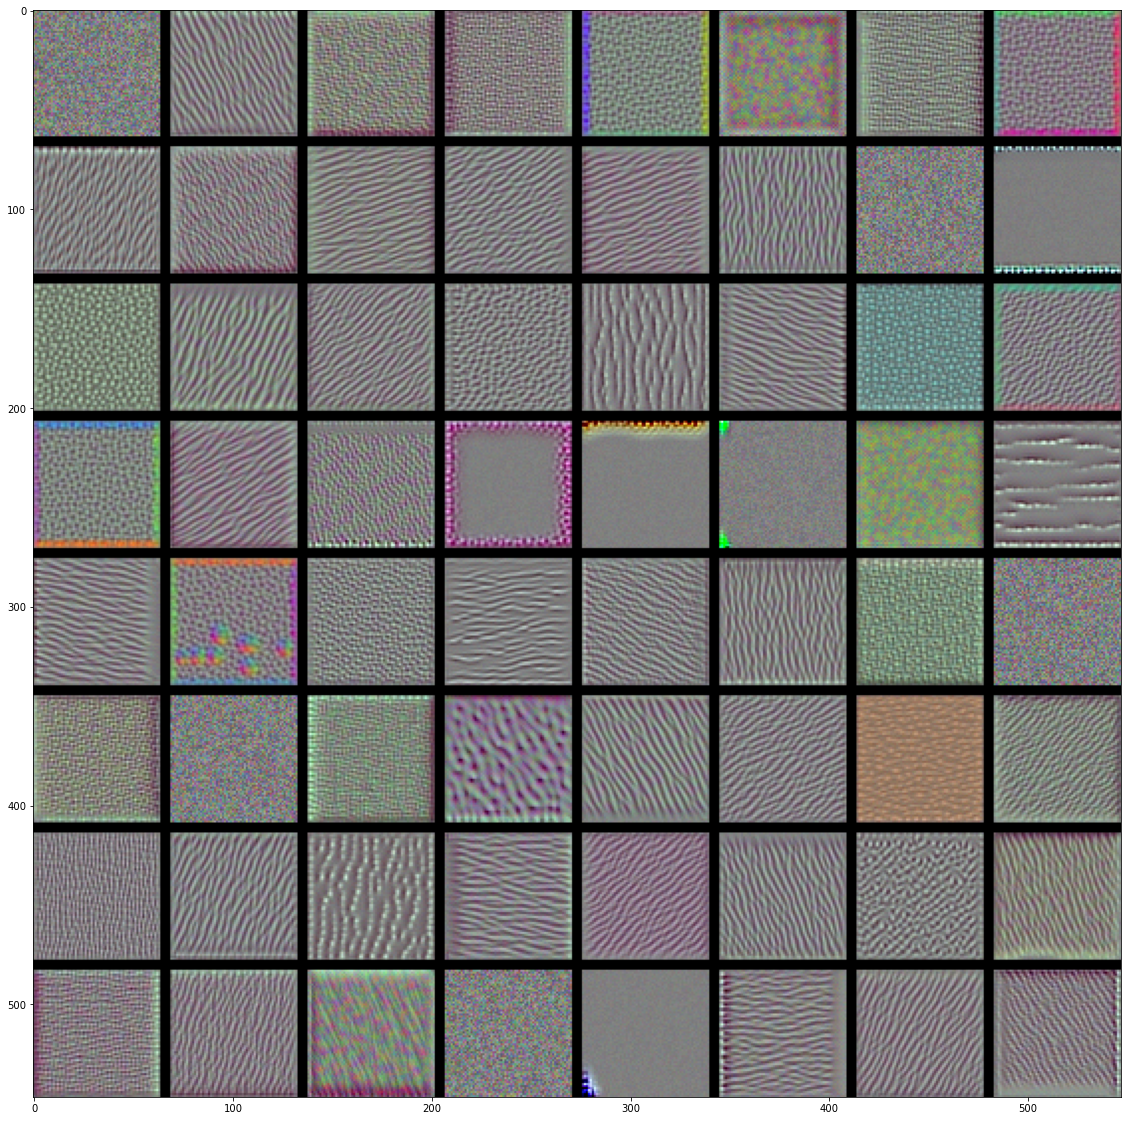

In [11]:
# 층에 있는 각 필터에 반응하는 패턴 생성하기
layer_name = 'block2_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
               vertical_start: vertical_end, :] = filter_img
        
    
plt.figure(figsize=(20, 20))
plt.imshow(results)

In [3]:
model = VGG16(weights='imagenet')# 최상단의 완전 연결 분류기 포함

In [29]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions


img_path = './data/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224,224))

x = image.img_to_array(img)

x = np.expand_dims(x,axis=0)

x = preprocess_input(x)

In [30]:
preds = model.predict(x)

In [31]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.90988606), ('n01871265', 'tusker', 0.08572466), ('n02504013', 'Indian_elephant', 0.0043471307)]


In [32]:
np.argmax(preds[0])

386

In [33]:
broom_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(broom_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],
                    [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

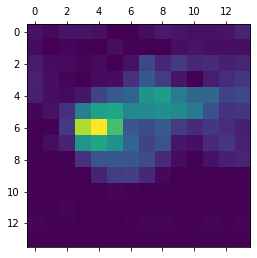

In [34]:
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [35]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img #0.4는 히트맴의 강도

cv2.imwrite('./data/test_img.jpg', superimposed_img) # 디스크에 이미지를 저장

True